# Data loading

This notebook loads the raw data and the pre-processed files generated by the YASS library, we will use one of those files as input for the clustering algorithm.

In [2]:
import logging
import os

import numpy as np

from yass.neuralnet import NeuralNetDetector
from yass.config import Config

from neural_clustering.explore import (SpikeTrainExplorer,
                                       RecordingExplorer)
from neural_clustering import config


import matplotlib.pyplot as plt

/Users/Edu/miniconda3/envs/test-project/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 10)

In [4]:
logging.basicConfig(level=logging.ERROR)

# Loading configuration files and YASS output

YASS is a Python package for spike sorting, which is being developed by Peter Lee (PhD in the Stats department and me): https://github.com/paninski-lab/yass

Someone in the lab implemented a truncated DPMM using numpy. Since the code is hard to debug and the only person who understands it is the person who wrote it, I want to see if we can start using Edward instead, so we can iterate quickly and prototype new models easily – without having to write custom inference algorithms every time.


In [5]:
# load configuration files
cfg_yass = Config.from_yaml('../yass_config/demo.yaml')
cfg = config.load('../config.yaml')

In [6]:
# load data generated from yass, we are only interested
# in spike_times and clear_index but we need to load all of them
# to instantiate the explorers that implement the functions we will
# use
files = ['score', 'clear_index', 'spike_times',
         'spike_train', 'spike_left', 'templates']

(score, clear_index,
 spike_times, spike_train,
 spike_left, templates) = [np.load(os.path.join(cfg['root'], 'yass/{}.npy'.format(f))) for f in  files]

# Loading raw recordings, geometry file and projection matrix

We load raw data, standarized data and channel geometry (spatial location of electrodes)

In [7]:
# load raw recordings
path_to_raw_recordings = os.path.join(cfg_yass.root, '7ch.bin')
# load standarized recordings (these are raw recordings + filter + standarization)
path_to_recordings = os.path.join(cfg_yass.root, 'tmp/standarized.bin')
# load gemetry file (position for every electro)
path_to_geometry = os.path.join(cfg_yass.root, cfg_yass.geomFile)

In [8]:
# load projection matrix (to reduce dimensionality)
proj = NeuralNetDetector(cfg_yass).load_w_ae()

# Initialize explorers

This helper classes contain functions to plot the data.

In [10]:
# initialize explorers, these objects implement functions for plotting
# the output from YASS
explorer_rec = RecordingExplorer(path_to_recordings,
                                 path_to_geometry,
                                 dtype='float64',
                                 window_size=cfg_yass.spikeSize,
                                 n_channels=cfg_yass.nChan,
                                 neighbor_radius=cfg_yass.spatialRadius)

explorer_raw = RecordingExplorer(path_to_raw_recordings,
                                 path_to_geometry,
                                 dtype='int16',
                                 window_size=cfg_yass.spikeSize,
                                 n_channels=cfg_yass.nChan,
                                 neighbor_radius=cfg_yass.spatialRadius)


explorer_train = SpikeTrainExplorer(templates,
                                    spike_train,
                                    explorer_rec,
                                    proj)

In [16]:
print('Observations: {}. Channels: {}'.format(*explorer_raw.data.shape))

Observations: 6000000. Channels: 7


# Raw recordings

The timeseries plot shows how the raw data looks like in every channel.

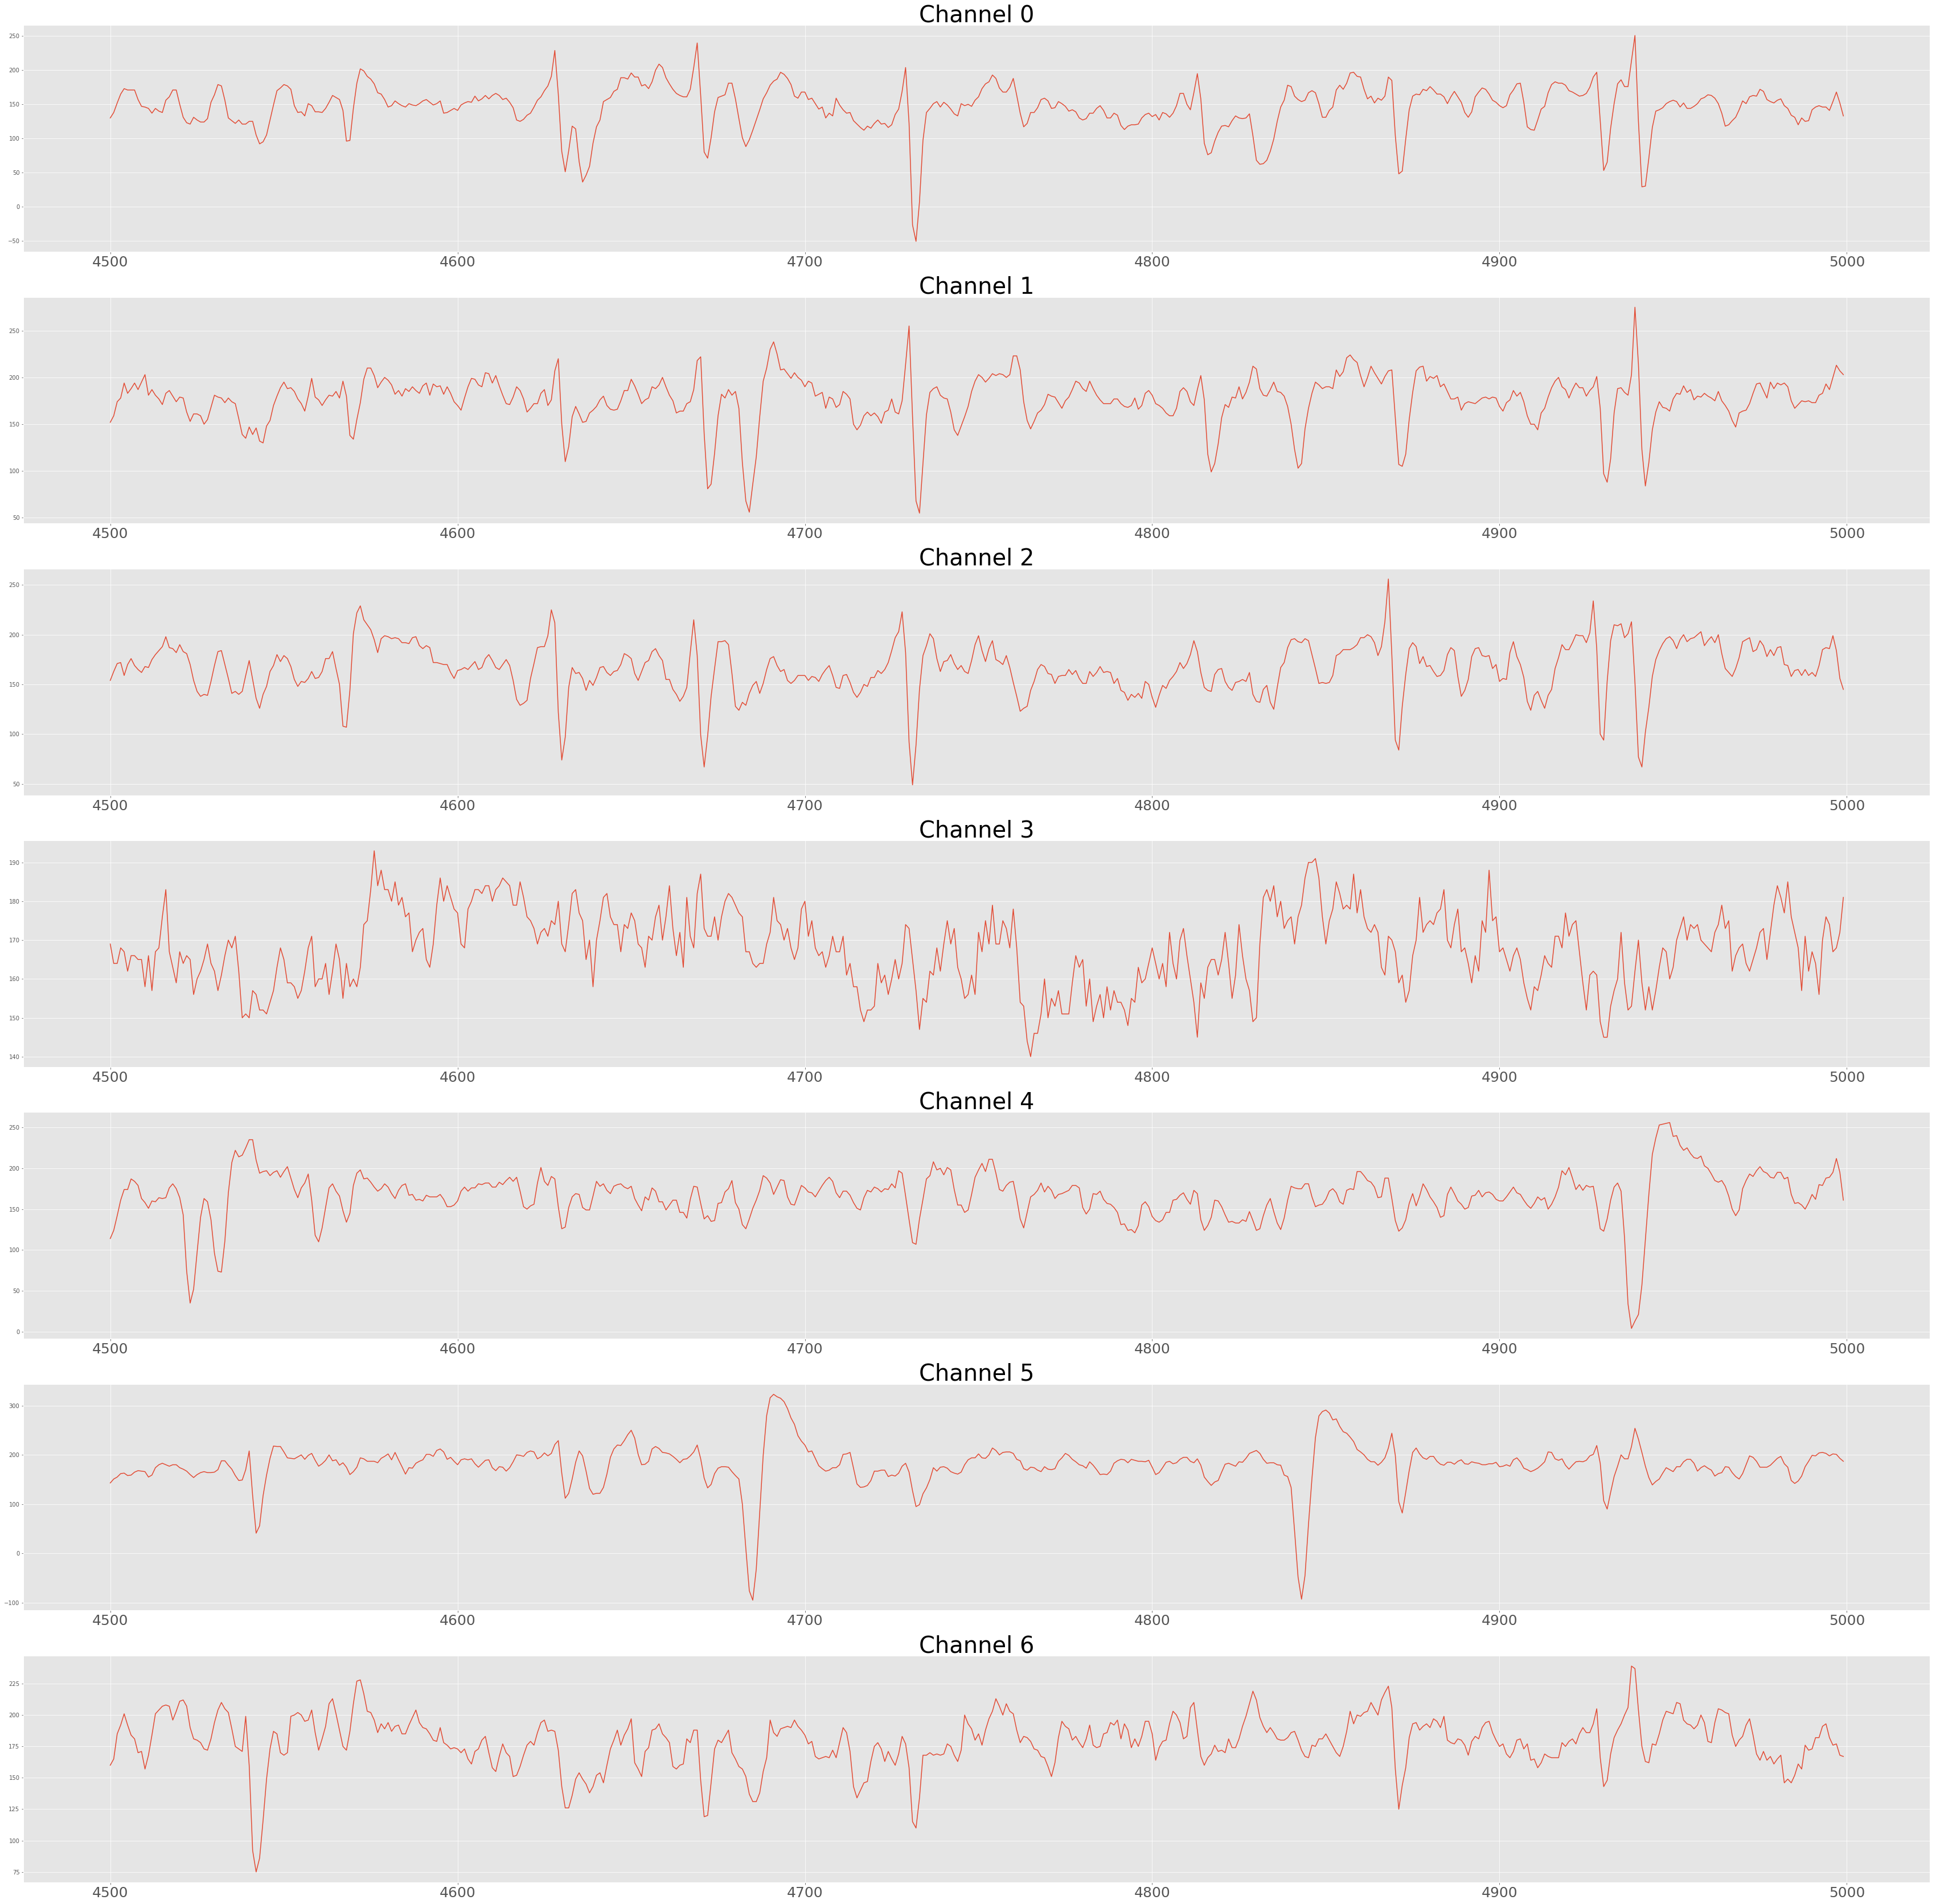

In [17]:
plt.rcParams['figure.figsize'] = (60, 60)
explorer_raw.plot_series(from_time=4500, to_time=5000)

## Filtered + Standarized Recordings

The timeseries plot shows how the filtered + standarized data looks like in every channel.

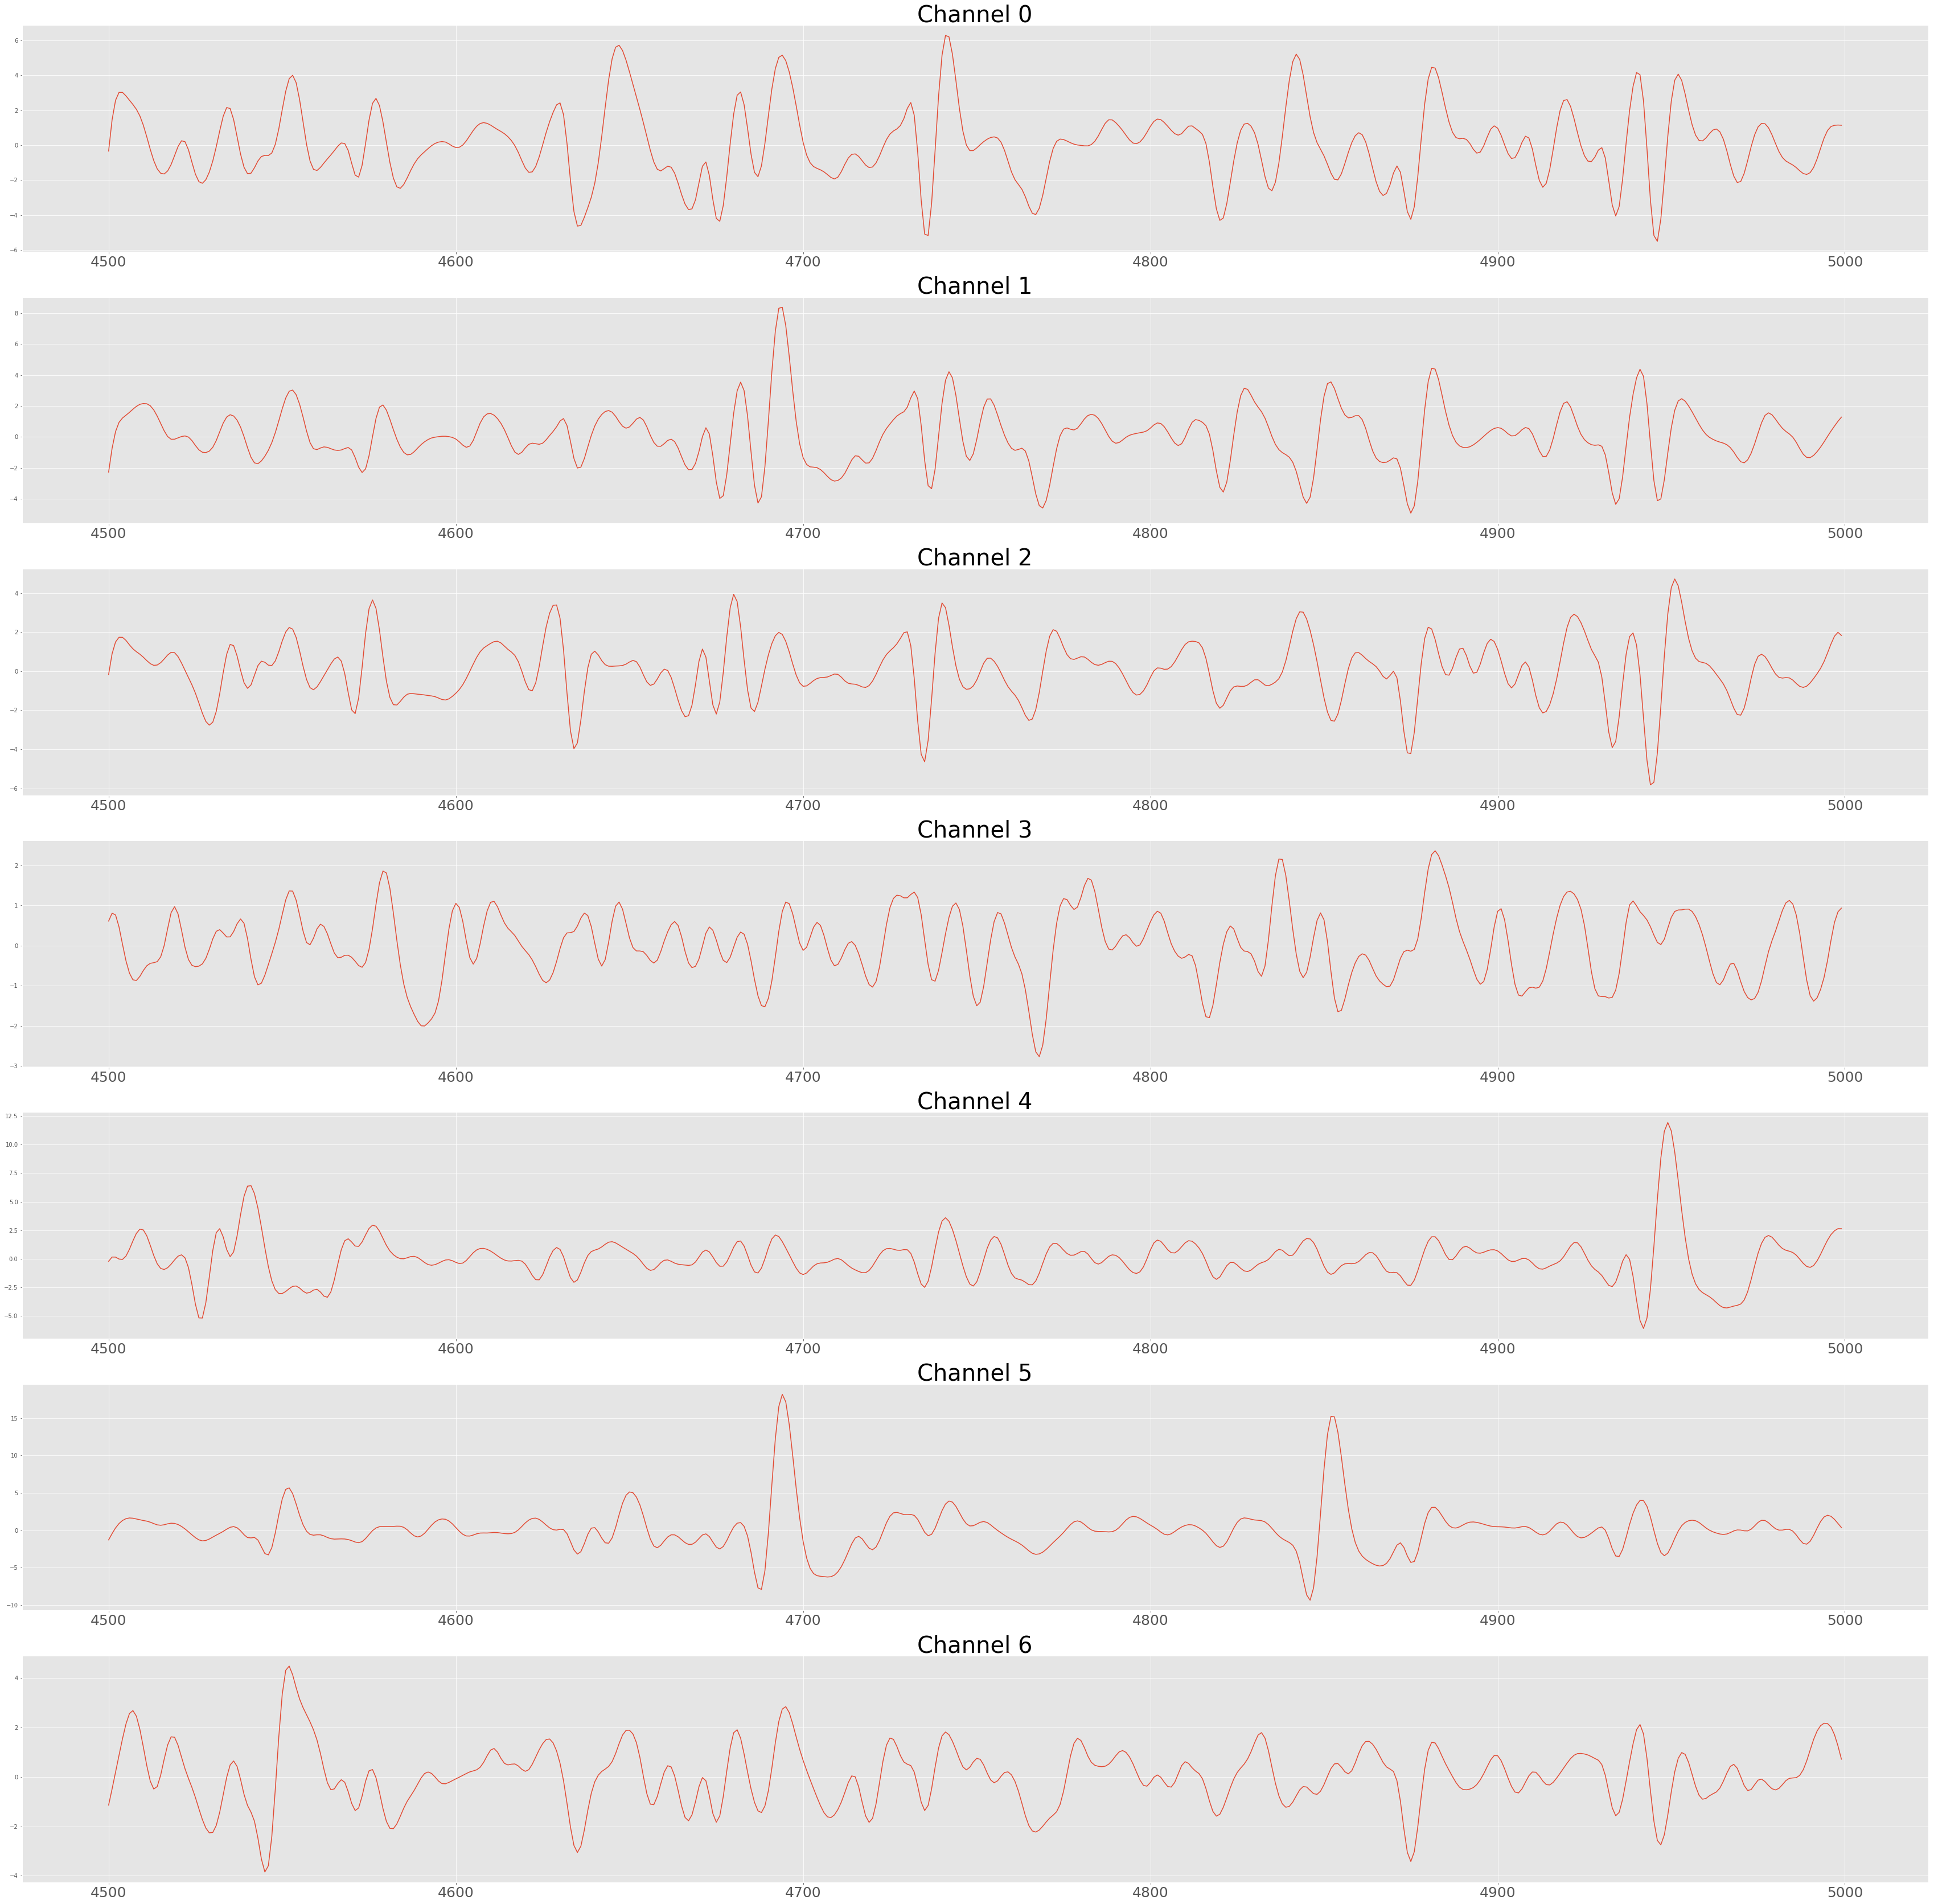

In [18]:
explorer_rec.plot_series(from_time=4500, to_time=5000)

# Geometry

Electoreds spatial location plot.

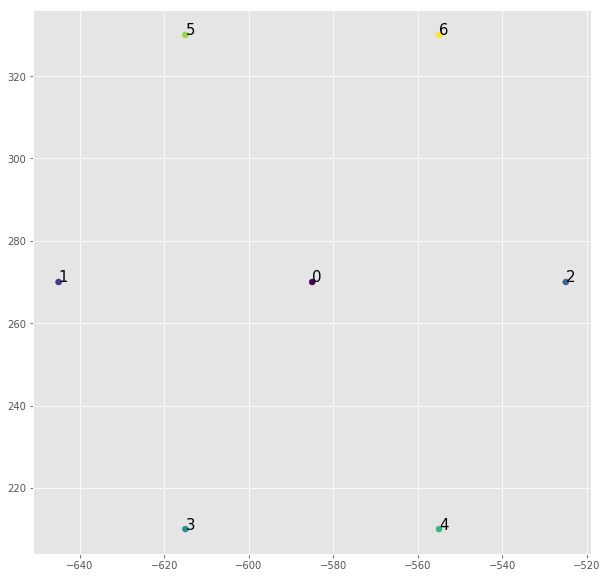

In [12]:
plt.rcParams['figure.figsize'] = (10, 10)
explorer_rec.plot_geometry()

# Training data

## Load clear spike times in channel 0

To quickly iterate over models, we are only training using spikes from channel 0.

In [19]:
clear_indexes = clear_index[0]
clear_spikes = spike_times[0][clear_indexes, 0]

In [20]:
all_spike_times = np.vstack(spike_times)[:, 0]
print('Detected {} clear spikes'.format(clear_spikes.shape[0]))

Detected 1876 clear spikes


In [15]:
# there is a bug in yass 0.1.1 that is shifting spike times
clear_spikes = clear_spikes - cfg_yass.BUFF

In [16]:
clear_spikes

array([   4184,    4747,    5594, ..., 5978986, 5984129, 5987587], dtype=int32)

# Visualizing a spike

Plot for a single detected spike.

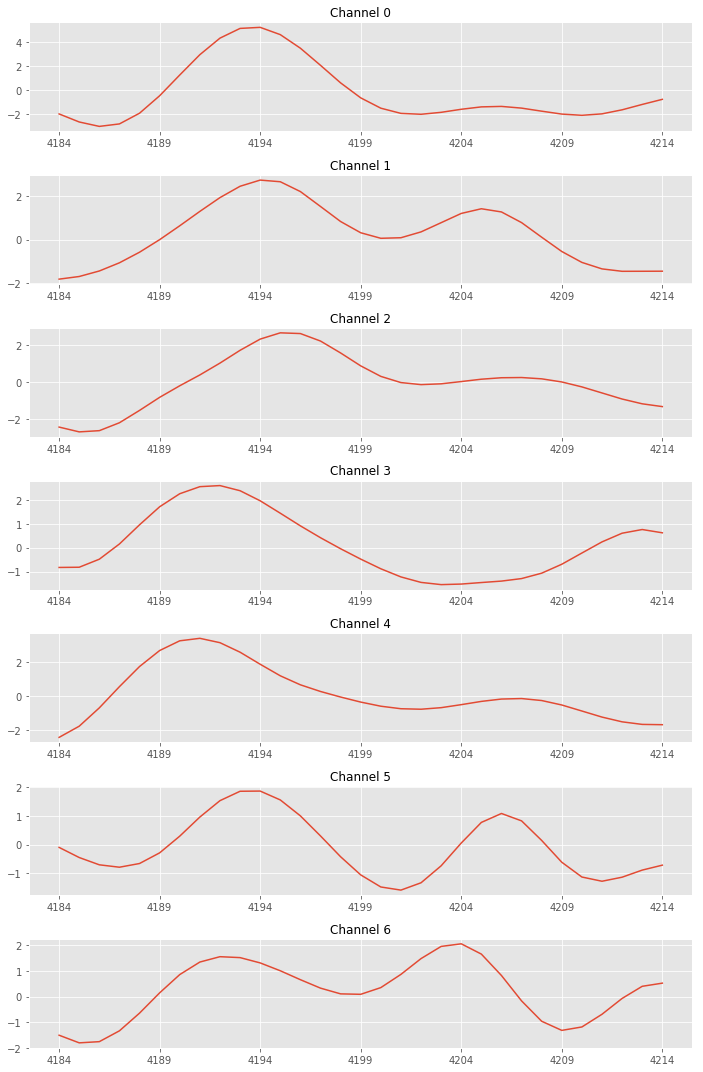

In [17]:
plt.rcParams['figure.figsize'] = (10, 15)
t = clear_spikes[0]
explorer_rec.plot_waveform(time=t, channels=range(7))

## Load waveforms around spike times

Once we hace spike times, we need to load a time window around it, we load 15 observations before and after,
so we have 31 temporal observations per spike.

In [20]:
waveforms = explorer_rec.read_waveforms(times=clear_spikes)
print('Training set dimensions: {}'.format(waveforms.shape))

Training set dimensions: (1876, 31, 7)


## Reduce waveforms temporal dimensionality from 31 to 3 and flatten data

We reduce temporal dimensionality (from 31 to 3) in each channel using an autoencoder, so we get 3 * n_channels = 21 features for the training data.

In [21]:
waveforms_reduced = explorer_train._reduce_dimension(waveforms, flatten=True)
print('Training set dimensions: {}'.format(waveforms_reduced.shape))

Training set dimensions: (1876, 21)


# Save training data and clear spike times

We save the training data and clear spike times (we will later use the spike times for visualization)

In [22]:
output_path = os.path.join(cfg['root'], 'training.npy')
np.save(output_path, waveforms_reduced)
print(f'Saved training data in {output_path}')

Saved training data in /Users/Edu/data/neural-clustering/training.npy


In [23]:
output_path = os.path.join(cfg['root'], 'clear_spikes.npy')
np.save(output_path, clear_spikes)
print(f'Saved clear spike times in {output_path}')

Saved clear spike times in /Users/Edu/data/neural-clustering/clear_spikes.npy
